# Connecting to kaggle dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# @title Downloading the vehicle-detection-image-set dataset
! kaggle datasets download -d brsdincer/vehicle-detection-image-set
! mkdir -p "/content/gdrive/MyDrive/Datasets/vehicle_data"
! unzip vehicle-detection-image-set.zip -d "/content/gdrive/MyDrive/Datasets/vehicle_data"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open vehicle-detection-image-set.zip, vehicle-detection-image-set.zip.zip or vehicle-detection-image-set.zip.ZIP.


# Import modules

In [ ]:
import os
import re
import cv2
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score,
                             log_loss,
                             confusion_matrix,
                             ConfusionMatrixDisplay)

%matplotlib inline

# Data Preparation and Preprocessing

In [ ]:
# @title Base directory of the dataset
base_dir = "/content/gdrive/MyDrive/Datasets/vehicle_data/data/"

In [ ]:
label = set()    #  Assign all label
images_path = [] # Get all images path
img_label = []   # Assign image label


for directory in os.listdir(base_dir):
    label.add(directory)
    for img in os.listdir(os.path.join(base_dir,directory)):
        if len(re.findall('.png',img.lower())) != 0 or len(re.findall('.jpg',img.lower())) != 0 or len(re.findall('.jpeg',img.lower())) != 0:
            img_path = os.path.join(os.path.join(base_dir,directory),img)
            images_path.append(img_path)
            img_label.append(directory)

In [ ]:
img_shape = cv2.imread(images_path[0])

print(f"Labels : {label}")
print(f"Total Images : {len(images_path)}")
print(f"Images shape : {img_shape.shape}")

Labels : {'vehicles', 'non-vehicles'}
Total Images : 17760
Images shape : (64, 64, 3)


In [ ]:
data = pd.DataFrame({'image':images_path,'label':img_label})
data

,image,label
0,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
1,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
2,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
3,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
4,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
...,...,...
17755,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles
17756,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles
17757,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles
17758,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles


In [ ]:
data = data.sample(frac=1).reset_index()
data.head(8)

,index,image,label
0,14718,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles
1,1127,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
2,2326,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
3,15882,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles
4,685,/content/gdrive/MyDrive/Datasets/vehicle_data/...,non-vehicles
5,15875,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles
6,10603,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles
7,13036,/content/gdrive/MyDrive/Datasets/vehicle_data/...,vehicles


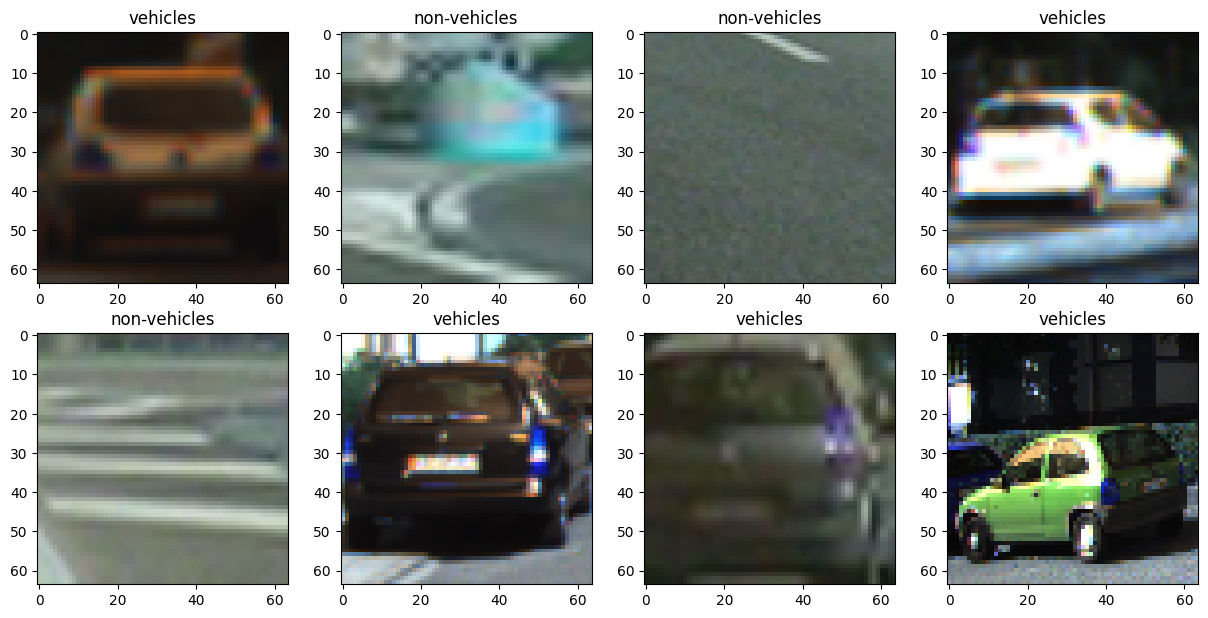

In [ ]:
fig = plt.figure(figsize=(15,15))

for i in range(8):
    fig.add_subplot(4,4,i+1).set_title(data['label'][i])
    img = cv2.imread(data['image'][i])
    plt.imshow(img)

plt.show()

# Splitting the data

For this lab, I will use only 400 images instead of 17700 since training all of them will take huge amount of time

In [ ]:
df = data.sample(400)
imagePaths = df['image']
labels = df['label']

In [ ]:
def image_to_feature_vector(image_path, size=(64, 64)):
	# resize the image to a fixed size, then flatten the image into
	# a list of raw pixel intensities
	img = cv2.imread(img_path)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	return cv2.resize(image_path, size).flatten()


rawImages = []

for (i, imagePath) in enumerate(imagePaths):
	image = cv2.imread(imagePath)
	pixels = image_to_feature_vector(image)

	rawImages.append(pixels)

	# show an update every 100 images until the last image
	if i > 0 and ((i + 1)% 100 == 0 or i == len(imagePaths)-1):
		print("[INFO] processed {}/{}".format(i+1, len(imagePaths)))

rawImages = np.array(rawImages)
print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))

[INFO] processed 100/400
[INFO] processed 200/400
[INFO] processed 300/400
[INFO] processed 400/400
[INFO] pixels matrix: 4.80MB


In [ ]:
# @title Train: 80% | Test: 20%

X_train, X_test, y_train, y_test = skm.train_test_split(rawImages, labels, test_size=0.2, stratify=labels, random_state=42)

# Task 1

In [ ]:
# Plot CV results function
def plotCV(x_values, clf, label="", plt_type='linear', figsize=(8, 6)):
  plt.figure(figsize=figsize)
  if len(label) > 0:
    plt.title(f"Cross validation scores for {label}")
    plt.xlabel(f"{label}")
  else:
    plt.title(f"Cross validation scores")
    plt.xlabel("Configuration")

  if plt_type == 'linear':
    plt.plot(range(len(x_values)), clf.cv_results_['mean_train_score'], lw=1, color="red", label="Training Accuracy")
    plt.plot(range(len(x_values)), clf.cv_results_['mean_test_score'], lw=3, color="blue", label="Validation Accuracy")
    plt.xticks(range(len(x_values)), x_values)
  elif plt_type == 'bar':
    width = 0.3
    plt.bar(np.arange(len(x_values)) - width/2, clf.cv_results_['mean_train_score'], width, color="purple", label='Training Accuracy')
    plt.bar(np.arange(len(x_values)) + width/2, clf.cv_results_['mean_test_score'], width, color="yellow", label='Validation Accuracy')
    plt.xticks(range(len(x_values)), x_values)

  plt.ylabel("Score")
  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()

  best_ = clf.best_params_
  print("Best parameters found: ", best_)
  return best_


In [ ]:
hidden_layer_sizes = [(10,), (20,), (50,), (100,)]

clf1 = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42),
                                {'hidden_layer_sizes': hidden_layer_sizes},
                                cv=5,
                                scoring='accuracy',
                                return_train_score=True)
clf1.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=42),
             param_grid={'hidden_layer_sizes': [(10,), (20,), (50,), (100,)]},
             return_train_score=True, scoring='accuracy')

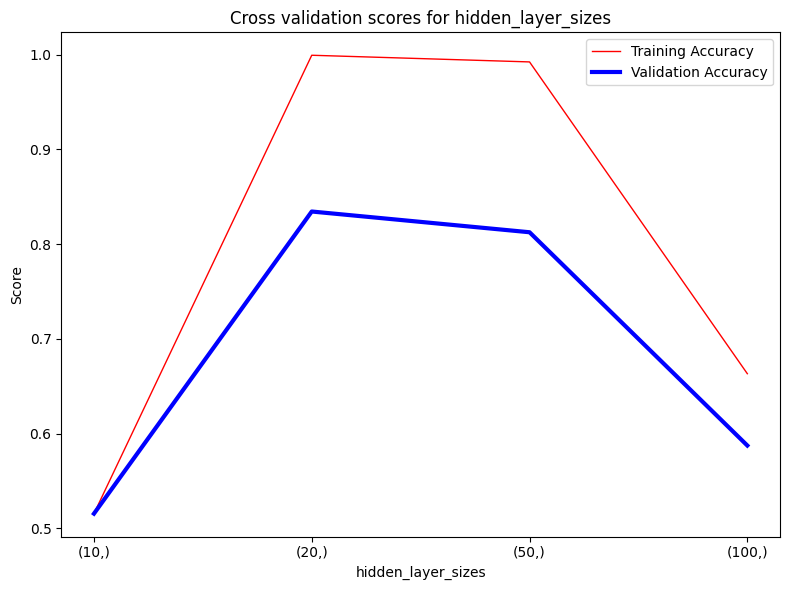

Best parameters found:  {'hidden_layer_sizes': (20,)}


In [ ]:
best_params = plotCV(hidden_layer_sizes, clf1, label="hidden_layer_sizes")
hidden_layer_best = best_params['hidden_layer_sizes']

In [ ]:
activation_functions = ['identity', 'logistic', 'tanh', 'relu']

clf2 = GridSearchCV(MLPClassifier(hidden_layer_sizes=hidden_layer_best, max_iter=1000, random_state=42),
                    {'activation': activation_functions},
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True)
clf2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000,
                                     random_state=42),
             param_grid={'activation': ['identity', 'logistic', 'tanh',
                                        'relu']},
             return_train_score=True, scoring='accuracy')

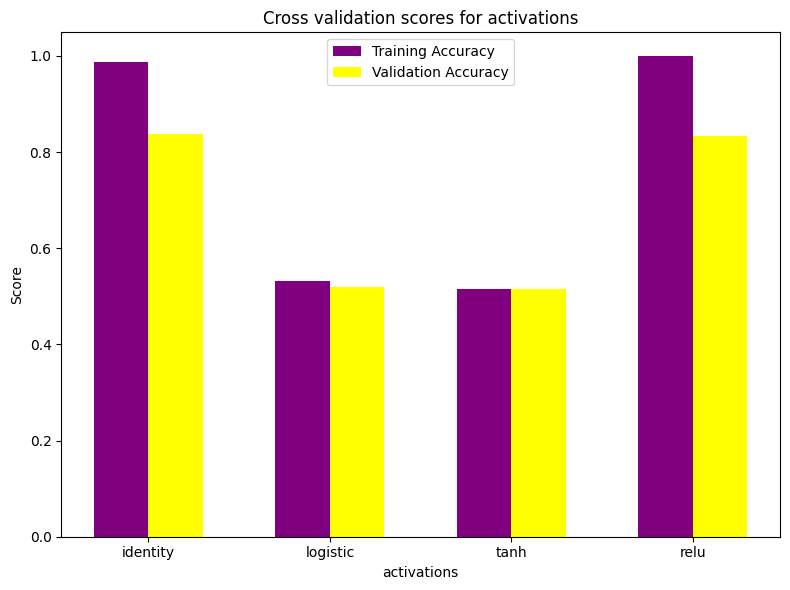

Best parameters found:  {'activation': 'identity'}


In [ ]:
best_params = plotCV(activation_functions, clf2, label="activations", plt_type="bar")
activation_best = best_params['activation']

In [ ]:
solvers = ['lbfgs', 'sgd', 'adam']

clf3 = GridSearchCV(MLPClassifier(hidden_layer_sizes=hidden_layer_best, activation=activation_best, max_iter=1000, random_state=42),
                    {'solver': solvers},
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True)
clf3.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='identity',
                                     hidden_layer_sizes=(20,), max_iter=1000,
                                     random_state=42),
             param_grid={'solver': ['lbfgs', 'sgd', 'adam']},
             return_train_score=True, scoring='accuracy')

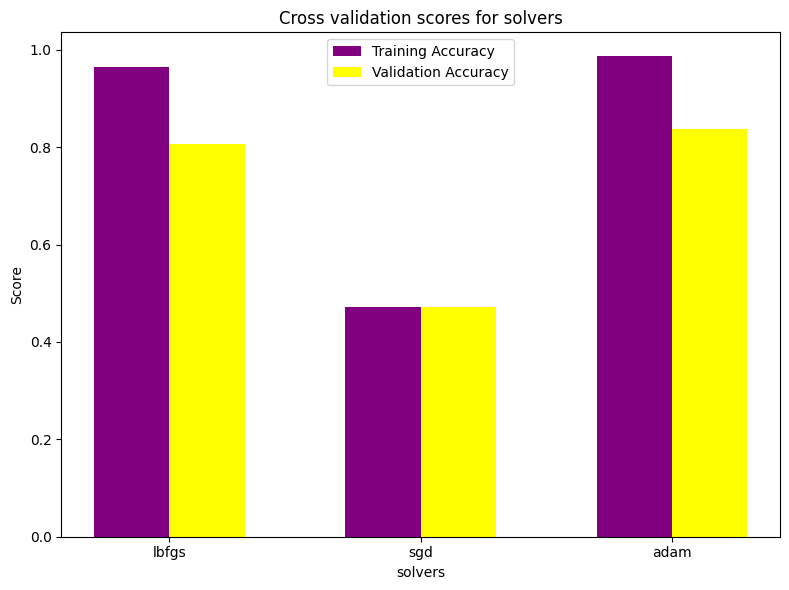

Best parameters found:  {'solver': 'adam'}


In [ ]:
best_params = plotCV(solvers, clf3, label="solvers", plt_type="bar")
solver_best = best_params['solver']

# Task 2

In [ ]:
hidden_layer_sizes = [(10,), (20,), (50,)]
activation_functions = ['identity', 'logistic', 'tanh', 'relu']
solvers = ['sgd', 'adam']

param_grid = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': activation_functions,
    'solver': solvers
}

clf4 = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42),
                   param_grid,
                   cv=5,
                   return_train_score=True)
clf4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=2000, random_state=42),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(10,), (20,), (50,)],
                         'solver': ['sgd', 'adam']},
             return_train_score=True)

In [ ]:
print("Best parameters found: ", clf4.best_params_)

Best parameters found:  {'activation': 'identity', 'hidden_layer_sizes': (50,), 'solver': 'adam'}


# Results comparison

### Task 1 results:

Test set accuracy: 0.8500


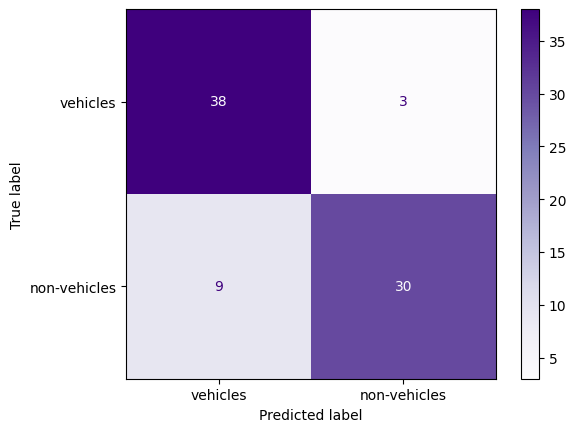

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_best, activation=activation_best, solver=solver_best, max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
print('Test set accuracy: %.4f' % accuracy_score(y_test, mlp.predict(X_test)))
task1_results = {**clf2.best_params_, **clf1.best_params_, **clf3.best_params_}
pd.DataFrame(task1_results, index=['Values']).transpose()

disp = ConfusionMatrixDisplay.from_estimator(
        mlp,
        X_test,
        y_test,
        display_labels=label,
        cmap=plt.cm.Purples,
    )

### Task 2 results:

Test set accuracy: 0.8625


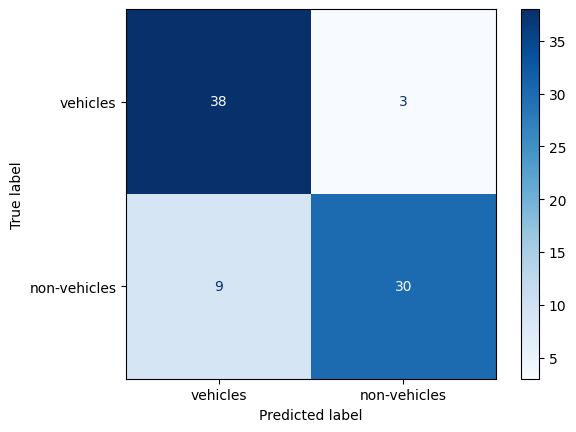

In [ ]:
best_estimator = clf4.best_estimator_
print('Test set accuracy: %.4f' % accuracy_score(y_test, best_estimator.predict(X_test)))
pd.DataFrame(clf4.best_params_, index=['Values']).transpose()

disp = ConfusionMatrixDisplay.from_estimator(
        mlp,
        X_test,
        y_test,
        display_labels=label,
        cmap=plt.cm.Blues,
    )

As it may be seen from the results, the accuracy of the estimator after global optimization is higher  than after local optimizations. However, they almost identical to each other which means that the results after both optimizations reaffirm each other. The prediction score on the test set is a bit higher than 85%. This score can further be improved if we use more datasets. For this lab, I used only 400 images out of 17K. Hence, the prediction in my case has relatively good accuracy.